In [12]:
import cv2
import matplotlib.pyplot as plt
import os

In [32]:
def draw_yolo_bounding_box(img, x_center, y_center, width, height):
    """
    Draws a bounding box on the image using YOLO format coordinates.

    Parameters:
    - img: The image on which to draw the bounding box.
    - x_center, y_center, width, height: YOLO format coordinates (normalized).

    Returns:
    - img: The image with the bounding box drawn.
    """
    img_height, img_width = img.shape[:2]
    
    # Convert normalized coordinates to absolute coordinates
    x_center_abs = float(x_center) * img_width
    y_center_abs = float(y_center) * img_height
    width_abs = float(width) * img_width
    height_abs = float(height) * img_height
    
    # Calculate top-left and bottom-right coordinates
    x1 = int(x_center_abs - width_abs / 2)
    y1 = int(y_center_abs - height_abs / 2)
    x2 = int(x_center_abs + width_abs / 2)
    y2 = int(y_center_abs + height_abs / 2)
    
    # Draw the bounding box on the image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return img


def load_yolo_annotations(annotation_path) -> list:
    """
    Loads YOLO annotations from a text file.

    Parameters:
    - annotation_path: Path to the annotation file.

    Returns:
    - annotations: List of YOLO annotations.
    """
    annotations = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = parts
                annotations.append((class_id, x_center, y_center, width, height))
    return annotations

In [36]:
frame = 'quantex_at_home_id257511_2021_07_12_01_000000'
image_path = f'../../../ProcessedData/images/{frame}.jpg'
img = cv2.imread(image_path)

img_height, img_width = img.shape[:2]
img_height, img_width


(720, 1280)

('1', '0.507734375', '0.70625', '972.6', '718.5')


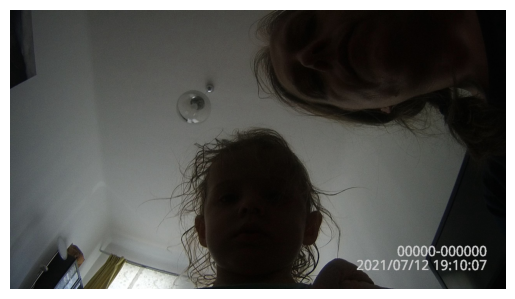

In [51]:
# Paths to the image and annotation file
frame = 'quantex_at_home_id257511_2021_07_12_01_000000'
image_path = f'../../../ProcessedData/images/{frame}.jpg'  
annotation_path_1 = f'../../../ProcessedData/yolo/labels/train/{frame}.txt'  
annotation_path_2 = f'../../../ProcessedData/yolo/labels/val/{frame}.txt'  

# if os.path.exists(annotation_path_1):
#     annotation_path = annotation_path_1
# elif os.path.exists(annotation_path_2):
#     annotation_path = annotation_path_2
# else:
#     raise FileNotFoundError(f"Annotation file not found in either directory for frame: {frame}")

annotation_path = 'quantex_at_home_id257511_2021_07_12_01_000000.txt'
# Load the image
img = cv2.imread(image_path)

# Load YOLO annotations
annotations = load_yolo_annotations(annotation_path)

# Draw bounding boxes for all annotations
for annotation in annotations:
    print(annotation)
    class_id, x_center, y_center, width, height = annotation
    img = draw_yolo_bounding_box(img, x_center, y_center, width, height)

# Convert BGR image to RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()


In [48]:
def convert_to_yolo_format(
    image_path, bbox
) -> list:
    """
    This function converts the given annotations to YOLO format.

    Parameters
    ----------
    image_path : str
        the path to the image file
    bbox : list
        the bounding box coordinates

    Returns
    -------
    annotations : list
        the annotations in YOLO format
    """
    # Load the image to get its dimensions
    img = cv2.imread(image_path)
    img_height, img_width = img.shape[:2]

    xtl, ytl, xbr, ybr = bbox

    # Calculate center coordinates
    x_center = (xtl + xbr) / 2.0
    y_center = (ytl + ybr) / 2.0
    
    # Calculate width and height
    width = xbr - xtl
    height = ybr - ytl
    
    # Normalize by image dimensions
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    
    # Return in YOLO format
    return (x_center, y_center, width, height)

In [38]:
x_center

'327.2'

In [9]:
import json
import logging
from pathlib import Path

file_contents = {}

for annotation in annotations[0:1]:
    _, _, category_id, bbox, image_file_name, _, = annotation
    bbox = json.loads(bbox)
    
    # Construct the path to the image file
    images_input = Path("../../../ProcessedData/images/")
    image_file_path = images_input / image_file_name
    
    # Check if the image file exists
    if not image_file_path.is_file():
        logging.warning(f"Image file {image_file_path} does not exist. Skipping annotation.")
        continue
            
    # Create a line for the text file
    line = f"{category_id} " + " ".join(map(str, bbox)) + '\n'
    # Append the line to the list of lines for the image file
    if image_file_name not in file_contents:
        file_contents[image_file_name] = []
    file_contents[image_file_name].append(line)

# Write the lines to text files
for image_file_name, lines in file_contents.items():
    file_name_without_extension = Path(image_file_name).stem
    txt_file = (file_name_without_extension + '.txt')
    try:
        with open(txt_file, 'w') as f:
            f.writelines(lines)
    except IOError as e:
        logging.error(f"Failed to write to file {txt_file}: {e}")


In [42]:
import sqlite3
conn = sqlite3.connect('../../../ProcessedData/databases/annotations.db')
cursor = conn.cursor()
query = """
SELECT DISTINCT a.image_id, a.video_id, a.category_id, a.bbox, i.file_name, v.file_name as video_file_name
FROM annotations a
JOIN images i ON a.image_id = i.frame_id AND a.video_id = i.video_id
JOIN videos v ON a.video_id = v.id
WHERE a.category_id != -1
ORDER BY a.video_id, a.image_id
"""
cursor.execute(query)

annotations = cursor.fetchall()
conn.close()

In [46]:
_, _, category_id, bbox, image_file_name, _ = annotations[0]
bbox = json.loads(bbox)
bbox

[327.2, 298.5, 972.6, 718.5]

In [49]:
convert_to_yolo_format(image_path, bbox)

(0.507734375, 0.70625, '972.6', '718.5')